In [1]:
import cv2
import numpy as np
import csv
import os
import matplotlib.pyplot as plt

In [5]:

# Helper: Rotate Template 
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# Match Template with Rotations and Scales
def match_template_with_rotations_and_scales(image, template, angles, scales, threshold=0.6):
    best_val = -1
    best_loc = None
    best_template_size = None

    for scale in scales:
        scaled_template = cv2.resize(template, (0, 0), fx=scale, fy=scale)

        for angle in angles:
            rotated_template = rotate_image(scaled_template, angle)

            if rotated_template.shape[0] > image.shape[0] or rotated_template.shape[1] > image.shape[1]:
                continue 

            result = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            print(f"Angle: {angle}°, Scale: {scale:.2f} → Match Score: {max_val:.4f}")

            if max_val > best_val and max_val >= threshold:
                best_val = max_val
                best_loc = max_loc
                best_template_size = rotated_template.shape[::-1]  # (width, height)

    if best_loc is not None:
        print(f"✅ Template matched with score: {best_val:.4f}")
        return best_loc, best_template_size
    else:
        print("❌ No good match found.")
        return None, None
    

# Adjust rectangle coordinates by a given factor
def adjustBox(boundingBoxCords, shrinkFactor=0.1, imageWidth=None, imageHeight=None):
    y1, x1, y2, x2 = boundingBoxCords 
    width = x2 - x1
    height = y2 - y1

    x1_new = x1 + int(width * shrinkFactor)
    y1_new = y1 + int(height * shrinkFactor)
    x2_new = x2 - int(width * shrinkFactor)
    y2_new = y2 - int(height * shrinkFactor)

    if imageWidth is not None and imageHeight is not None:
        x1_new = max(x1_new, 0)
        y1_new = max(y1_new, 0)
        x2_new = min(x2_new, imageWidth)
        y2_new = min(y2_new, imageHeight)

    return [y1_new, x1_new, y2_new, x2_new]


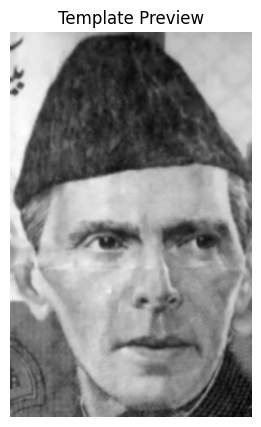

Angle: -90°, Scale: 0.90 → Match Score: 0.6610
Angle: -45°, Scale: 0.90 → Match Score: 0.5403
Angle: -15°, Scale: 0.90 → Match Score: 0.3818
Angle: 0°, Scale: 0.90 → Match Score: 0.3898
Angle: 15°, Scale: 0.90 → Match Score: 0.5221
Angle: 45°, Scale: 0.90 → Match Score: 0.5093
Angle: 90°, Scale: 0.90 → Match Score: 0.6539
Angle: -90°, Scale: 1.00 → Match Score: 0.7123
Angle: -45°, Scale: 1.00 → Match Score: 0.5270
Angle: -15°, Scale: 1.00 → Match Score: 0.4104
Angle: 0°, Scale: 1.00 → Match Score: 0.4080
Angle: 15°, Scale: 1.00 → Match Score: 0.5421
Angle: 45°, Scale: 1.00 → Match Score: 0.4984
Angle: 90°, Scale: 1.00 → Match Score: 0.6988
Angle: -90°, Scale: 1.10 → Match Score: 0.7401
Angle: -45°, Scale: 1.10 → Match Score: 0.5282
Angle: -15°, Scale: 1.10 → Match Score: 0.4167
Angle: 0°, Scale: 1.10 → Match Score: 0.4153
Angle: 15°, Scale: 1.10 → Match Score: 0.5618
Angle: 45°, Scale: 1.10 → Match Score: 0.5099
Angle: 90°, Scale: 1.10 → Match Score: 0.7197
✅ Template matched with scor

In [6]:
input_folder = 'Currency Note dataSet'
output_folder = 'Output_Images'
template_path = 'template_qq.jpg'
csv_output_path = 'detections.csv'

os.makedirs(output_folder, exist_ok=True)

# Preprocess Template 
template = cv2.imread(template_path)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.GaussianBlur(template, (5, 5), 0)

# View template
plt.figure(figsize=(5, 5))
plt.title("Template Preview")
plt.imshow(template, cmap='gray')
plt.axis('off')
plt.show()

csv_file = open(csv_output_path, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['ImageName', 'x1', 'y1', 'x2', 'y2'])  

for image_name in os.listdir(input_folder):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_folder, image_name)
        image = cv2.imread(image_path)
        original_image = image.copy()

        # Preprocess Input Image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        gray_image = cv2.equalizeHist(gray_image)

        # Template Match (with rotation and scaling)
        top_left, template_size = match_template_with_rotations_and_scales(
            gray_image, template,
            angles=[-90,-45,-15, 0,15, 45,90],
            scales=[0.9, 1.0, 1.1],
            threshold=0.6
        )

        if top_left is not None:
            x, y = top_left
            w, h = template_size

            # Rectangle for matched Quaid-e-Azam face (green)
            face_top_left = (x, y)
            face_bottom_right = (x + w, y + h)
            cv2.rectangle(original_image, face_top_left, face_bottom_right, (0, 255, 0), 2)

            # To set offset according to template size(scale)
            tr_offset = (1, 0.08) 
            tr_box_size = (1.3, 0.13)

            bl_offset = (-2.65, 0.93)
            bl_box_size = (1.4, 0.13)

            # Scale with current template size
            tr_offset_x = int(w * tr_offset[0])
            tr_offset_y = int(h * tr_offset[1])
            tr_box_width = int(w * tr_box_size[0])
            tr_box_height = int(h * tr_box_size[1])

            bl_offset_x = int(w * bl_offset[0])
            bl_offset_y = int(h * bl_offset[1])
            bl_box_width = int(w * bl_box_size[0])
            bl_box_height = int(h * bl_box_size[1])

            tr_start = (x + tr_offset_x, y + tr_offset_y)
            tr_end = (tr_start[0] + tr_box_width, tr_start[1] + tr_box_height)

            bl_start = (x + bl_offset_x, y + bl_offset_y)
            bl_end = (bl_start[0] + bl_box_width, bl_start[1] + bl_box_height)

            
            height, width = original_image.shape[:2]

            # Shrink both boxes using adjustBox
            tr_box = adjustBox([tr_start[1], tr_start[0], tr_end[1], tr_end[0]], shrinkFactor=0.1, imageWidth=width, imageHeight=height)
            bl_box = adjustBox([bl_start[1], bl_start[0], bl_end[1], bl_end[0]], shrinkFactor=0.1, imageWidth=width, imageHeight=height)

            # Draw adjusted rectangles (blue)
            cv2.rectangle(original_image, (tr_box[1], tr_box[0]), (tr_box[3], tr_box[2]), (255, 0, 0), 2)
            cv2.rectangle(original_image, (bl_box[1], bl_box[0]), (bl_box[3], bl_box[2]), (255, 0, 0), 2)

            # Save to CSV
            csv_writer.writerow([image_name,tr_box[1], tr_box[0], tr_box[3], tr_box[2], bl_box[1], bl_box[0], bl_box[3], bl_box[2]])


            # Save output image
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, original_image)


csv_file.close()
print("✅ All done. Check output images and detections.csv")